# Homework 2 - End to End Classification on Titanic Data

Imports

In [100]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# inline plot
% matplotlib inline
# default figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible
np.random.seed(42)
% config Completer.use_jedi = False

UsageError: Line magic function `%` not found.


In [101]:
from pathlib import Path
from typing import Tuple

#### Read the Data

In [102]:
data_dir_path = Path('..') / 'data'
train_df: pd.DataFrame = pq.read_table(data_dir_path / 'train.parquet', memory_map=True).to_pandas()
test_df: pd.DataFrame = pq.read_table(data_dir_path / 'test.parquet', memory_map=True).to_pandas()

#### First Impressions - basic analysis of the data

Some basic statistics on the data:

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [104]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Right away, we can see that the training set has information about 891 passengers, of which $\approx 38.4\%$ survived (and respectively, $\approx 61.6\%$ did not).

We can clearly spot, with a naked eye, that:
* The `Age` column has only $714 < 891$ entries.
* The `Cabin` column has $204 < 891$ entries.
* The `Embarked` column has $889 < 891$ entries.

which means there's some missing data right there.
It should be noted that the (non-missing) `Age` values are between 0.4 years (4.8 months) and 80 years, which is pretty diverse.

These conclusions can be verified:

In [105]:
total = train_df.isnull().sum().sort_values(ascending=False)
percentage = total / 891
missing_data = pd.concat([total, percentage], axis=1, keys=['Total Missing Entries', '% of Missing Entries'])
missing_data[missing_data['Total Missing Entries'] > 0]

,Total Missing Entries,% of Missing Entries
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


At this stage, the `Cabin` column might be a good candidate to drop, as it has more than $77\%$ of missing data.

### Contributions of different features

Now, let us investigate statistically (and graphically) the contributions of different features on survival:

#### Age and Sex

/opt/miniconda3/envs/orly_hw/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


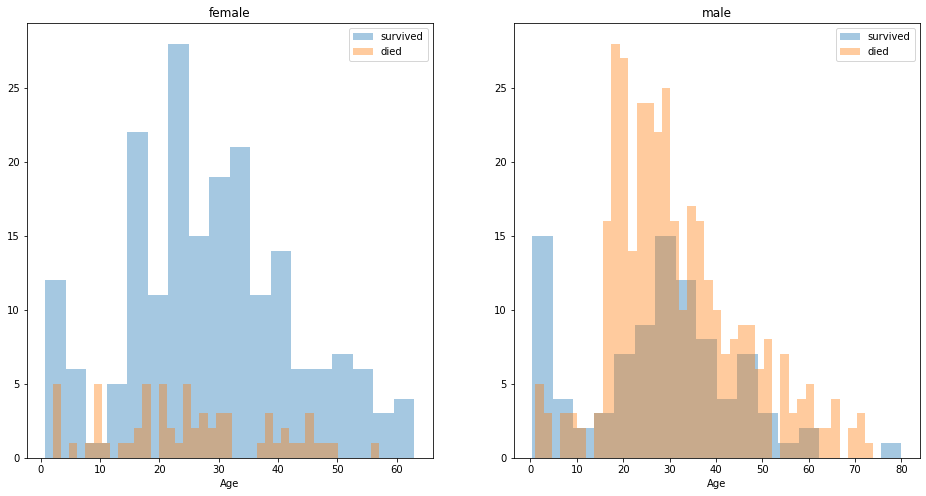

In [106]:
survived = 'survived'
died = 'died'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']

ax = sns.distplot(women[women['Survived'] == 1].Age.dropna(), bins=18, label=survived, ax=axes[0], kde=False)
ax = sns.distplot(women[women['Survived'] == 0].Age.dropna(), bins=40, label=died, ax=axes[0], kde=False)
ax.legend()
ax.set_title('female')

ax = sns.distplot(men[men['Survived'] == 1].Age.dropna(), bins=18, label=survived, ax=axes[1], kde=False)
ax = sns.distplot(men[men['Survived'] == 0].Age.dropna(), bins=40, label=died, ax=axes[1], kde=False)
ax.legend()
ax.set_title('male')

There seems to be some correlation between age groups for female/male subjects.

#### Embarked, Pclass (Passenger Class) and Sex:

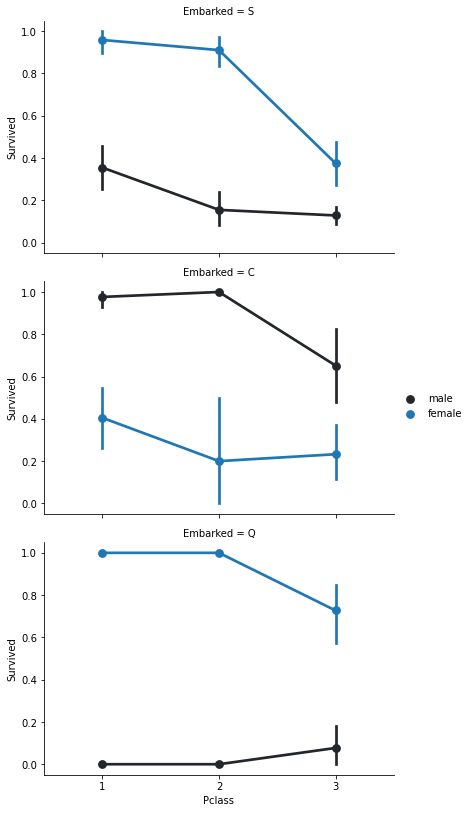

In [107]:
FacetGrid = sns.FacetGrid(data=train_df, row='Embarked', height=3.8, aspect=1.5)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None)
FacetGrid.add_legend()

We can see that women from the $1^{st}$ and $2^{nd}$ passenger classes have higher rates of survival than men when embarking on the Titanic in Southampton and Queenstown,
but men have higher rates of survival than women when embarking the Titanic in Cherbourg.

#### Pclass (Passenger Class)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

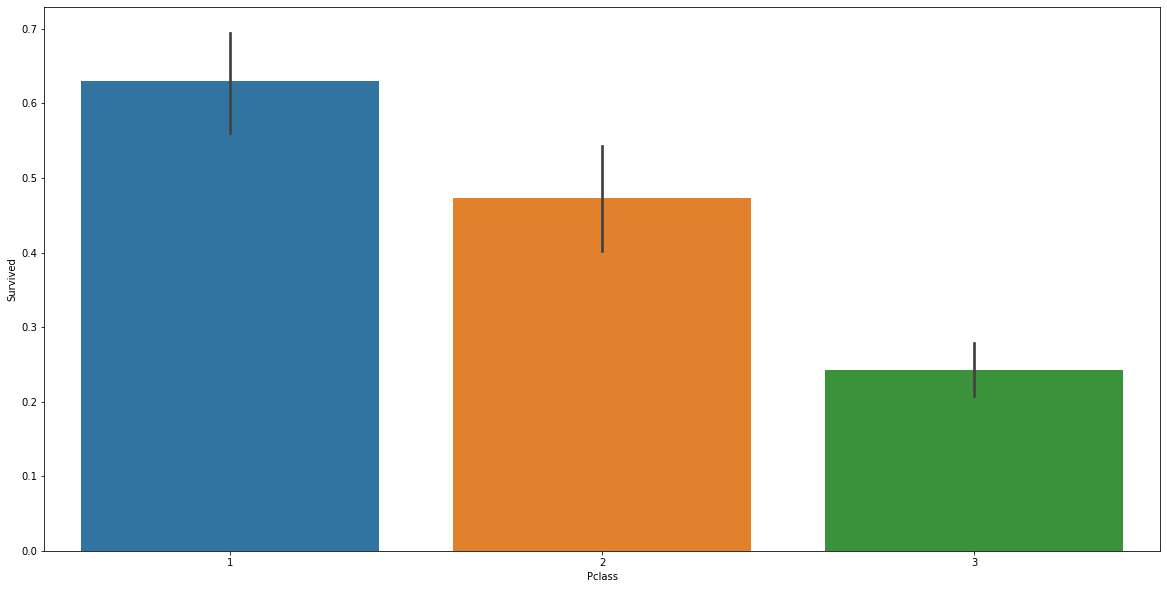

In [108]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

This corroborates our suspicion, that the higher the class $1^{st} > 2^{nd} > 3^{rd}$ $\Rightarrow$ the higher are the chances of survival.

#### SibSp and Parch:

Let us analyze the contributions of `SibSp` and `Parch`, separately and combined, since it might be more logical to look at their combined correlation to survival:

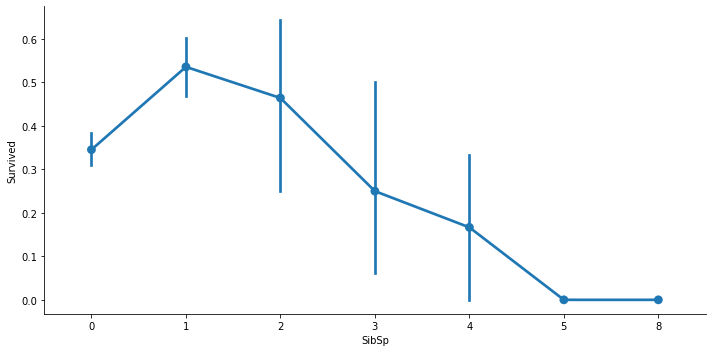

In [109]:
sns.catplot(data=train_df, x='SibSp', y='Survived', aspect=2, kind='point')

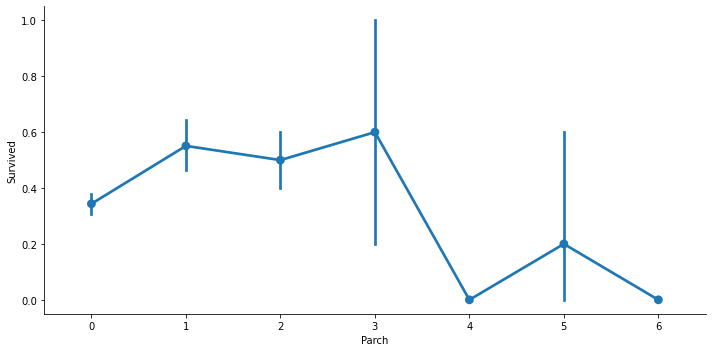

In [110]:
sns.catplot(data=train_df, x='Parch', y='Survived', aspect=2, kind='point')

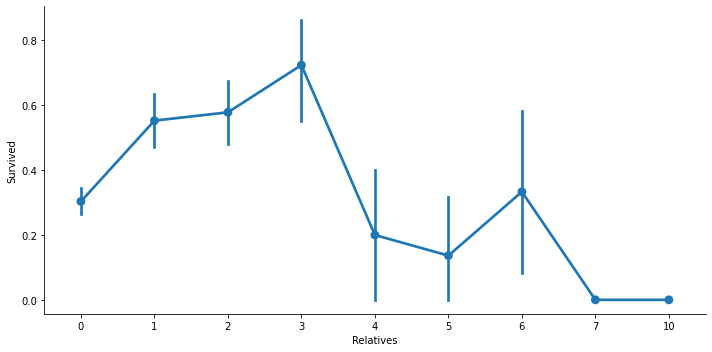

In [111]:
train_df['Relatives'] = train_df['SibSp'] + train_df['Parch']
sns.catplot(data=train_df, x='Relatives', y='Survived', aspect=2, kind='point')

Indeed, we see that passengers with 1-3 relatives (in total, siblings, spouses, children and parents) on-board have much higher sirvival rates.

### Feature Engineering

First, let us clean the data from non-relevant `PassengerId` and `Ticket` columns:

In [112]:
train_df.drop(columns=['PassengerId', 'Ticket'], inplace=True)

#### Missing Values and Manipulating Existing Features

Let us look again at the missing values and their numbers:

In [113]:
missing_data[missing_data['Total Missing Entries'] > 0]

,Total Missing Entries,% of Missing Entries
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


##### Embarked

This collumn has only 2 missing values. Hence, it seems sufficient to replace its missing values with the most common departure port

In [114]:
most_common_embarked = train_df['Embarked'].mode()[0]
# fill the missing cells, in-place, with 'S', which is the common value
train_df['Embarked'].fillna(most_common_embarked, inplace=True)

##### Age

This column has $\approx 20\%$ of its entries missing. Probably, the best way to counter it is by setting these missing values to the mean age. Or, even better, we can derive the mean and the std of the column, and then generate random normal data with it.

In [115]:
mean = train_df['Age'].mean()
std = train_df['Age'].std()
# random normal generator for ages missing values
num_of_missing_ages = train_df['Age'].isnull().sum()
missing_ages = np.random.normal(mean, std, size=num_of_missing_ages).clip(min=0)
# fill the missing values
train_df['Age'].loc[train_df['Age'].isnull()] = missing_ages

/opt/miniconda3/envs/orly_hw/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Now, we do not want to leave the `Age` column as a float column. It might be better to convert ages to groups of age ranges.
The logic here was finding a partition of approximately equal-sized groups.

In [273]:
train_df['Age_Groups'] = pd.cut(train_df['Age'], bins=[-1, 17, 22, 28, 35, 48, 80], labels=list(range(6)))
train_df['Age_Groups'].value_counts()

3    175
4    174
2    159
0    152
1    136
5     95
Name: Age_Groups, dtype: int64

##### Embarked

Let us turn this categorical column to numerical values.

In [170]:
train_df['Embarked_Numerical'] = pd.factorize(train_df['Embarked'])[0]
train_df['Embarked_Numerical'].value_counts()

0    646
1    168
2     77
Name: Embarked_Numerical, dtype: int64

##### Fare

Similarly to the `Age_Gropus` column, we would like to turn the float `Fare` column to groups of ticket price groups.
Once again, the logic was finding a partition of approximately equal-sized groups.

In [267]:
train_df['Fare_Groups'] = pd.cut(train_df['Fare'], bins=[-1, 8, 15, 31, 100, 1000], labels=list(range(5)))
train_df['Fare_Groups'].value_counts()

0    241
1    217
2    211
3    169
4     53
Name: Fare_Groups, dtype: int64

##### Name (Title)

Right away, we can see that all the name values are unique:

In [210]:
train_df['Name'].unique().shape[0]

891

But, let us take a closer look at the names:

In [219]:
train_df['Name'].sample(8)

1      Cumings, Mrs. John Bradley (Florence Briggs Th...
89                                Celotti, Mr. Francesco
626                       Kirkland, Rev. Charles Leonard
223                                 Nenkoff, Mr. Christo
845                                  Abbing, Mr. Anthony
655                            Hickman, Mr. Leonard Mark
214                                  Kiernan, Mr. Philip
531                                    Toufik, Mr. Nakli
Name: Name, dtype: object

We can see that these names (as well as all the other names in the dataset) include the titles: `Mr., Mrs., Miss.` etc.

Considering that these titles usually have high correlation to age, sex and status, this might be another helpful feature to use.

In [242]:
titles = train_df['Name'].str.extract(', ([A-Za-z ]+)\.', expand=False)
titles_counts = titles.value_counts().to_dict()
titles_counts

{'Mr': 517,
 'Miss': 182,
 'Mrs': 125,
 'Master': 40,
 'Dr': 7,
 'Rev': 6,
 'Mlle': 2,
 'Major': 2,
 'Col': 2,
 'the Countess': 1,
 'Capt': 1,
 'Ms': 1,
 'Sir': 1,
 'Lady': 1,
 'Mme': 1,
 'Don': 1,
 'Jonkheer': 1}

In [243]:
titles_translator = {t: t for t, c in titles_counts.items() if c >= 40}
titles_translator |= {t: 'Other' for t, c in titles_counts.items() if c < 40}
titles_translator |= {'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Miss', 'Mme': 'Mrs', 'Don': 'Master'}
train_df['Title'] = titles.map(titles_translator)
train_df['Title'].value_counts()

Mr        517
Miss      186
Mrs       126
Master     41
Other      21
Name: Title, dtype: int64

Now, like before, let us turn this `Title` column into a numerical `Title_Numerical` column:

In [245]:
train_df['Title_Numerical'] = pd.factorize(train_df['Title'])[0]
train_df['Title_Numerical'].value_counts()

0    517
2    186
1    126
3     41
4     21
Name: Title_Numerical, dtype: int64

##### Sex

Let us turn the `Sex` column to a numerical feature column:

In [246]:
train_df['Sex_Numerical'] = pd.factorize(train_df['Sex'])[0]
train_df['Sex_Numerical'].value_counts()

0    577
1    314
Name: Sex_Numerical, dtype: int64

#### Combining Existing Features to Create New Features

Let us create a new feature by combining a few others

##### Age times Passenger Class

This is a common technique for combining numerical features:

In [250]:
train_df['Age_Times_Class'] = train_df['Age'] * train_df['Pclass']

### Train Models

In [307]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

First, let us extract `X_train` and `y_train` data:

In [274]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Survived            891 non-null    int64   
 1   Pclass              891 non-null    int64   
 2   Name                891 non-null    object  
 3   Sex                 891 non-null    object  
 4   Age                 891 non-null    float64 
 5   SibSp               891 non-null    int64   
 6   Parch               891 non-null    int64   
 7   Fare                891 non-null    float64 
 8   Cabin               204 non-null    object  
 9   Embarked            891 non-null    object  
 10  Relatives           891 non-null    int64   
 11  Embarked_Numerical  891 non-null    int64   
 12  Age_Groups          891 non-null    category
 13  Fare_Groups         891 non-null    category
 14  Title               891 non-null    object  
 15  Title_Numerical     891 non-null    int6

In [275]:
X_train = train_df[['Pclass', 'Relatives', 'Embarked_Numerical', 'Age_Groups', 'Fare_Groups', 'Title_Numerical', 'Sex_Numerical', 'Age_Times_Class']]
y_train = train_df['Survived']

Here, we try out 3 different estimators (models) and calculate the train error for each:

In [309]:
#######################
# K-Nearest Neighbors #
#######################
# Define
knn = KNeighborsClassifier(n_neighbors=3)
# train
knn.fit(X_train, y_train)
# predict on training data
print(f'KNN train precision {knn.score(X_train, y_train)}')

#######################
#    Decision tree    #
#######################
# Define
decision_tree = DecisionTreeClassifier(random_state=42)
# train
decision_tree.fit(X_train, y_train)
# predict on training data
print(f'Decision Tree train precision {decision_tree.score(X_train, y_train)}')

###################
#  Random Forest  #
###################
# Define
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# train
random_forest.fit(X_train, y_train)
# predict on training data
print(f'Random Forest train precision {random_forest.score(X_train, y_train)}')

KNN train precision 0.8709315375982043
Decision Tree train precision 0.9685746352413019
Random Forest train precision 0.9685746352413019


Random Forest and Decision Tree seem the Best!!
Let us verify that with a 10-fold cross validation.

In [326]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

for classifier in [knn, decision_tree, random_forest]:
    # returns an array of scores of the classifier for each run of the cross validation.
    scores = cross_val_score(estimator=classifier, X=X_train, y=y_train,
                             scoring="accuracy", cv=10)
    model_type = classifier.__class__.__name__
    print(f'model type: {model_type}')
    print('=========================')
    display_scores(scores)
    print('-------------------------')

model type: KNeighborsClassifier
Scores: [0.67777778 0.7752809  0.70786517 0.80898876 0.78651685 0.74157303
 0.79775281 0.76404494 0.7752809  0.74157303]
Mean: 0.7576654182272161
Standard deviation: 0.038877793629068055
-------------------------
model type: DecisionTreeClassifier
Scores: [0.68888889 0.7752809  0.75280899 0.79775281 0.82022472 0.83146067
 0.83146067 0.7752809  0.7752809  0.76404494]
Mean: 0.7812484394506867
Standard deviation: 0.04071359163284769
-------------------------
model type: RandomForestClassifier
Scores: [0.7        0.85393258 0.74157303 0.80898876 0.84269663 0.83146067
 0.79775281 0.76404494 0.82022472 0.78651685]
Mean: 0.7947191011235955
Standard deviation: 0.045635270979020384
-------------------------


### Hyper Parameter Optimization - Random Forest

#### Grid Search

In [316]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30, 100], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 100], 'max_features': [2, 3, 4]},
  ]

forest = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
# return train score
# Computing training scores is used to get insights on how different
# parameter settings impact the overfitting/underfitting trade-off.
# However computing the scores on the training set can be computationally
# expensive and is not strictly required to select the parameters that
# yield the best generalization performance.

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10, 30, 100]}],
             return_train_score=True, scoring='accuracy')

In [317]:
print(f'''
best params: {grid_search.best_params_}
best estimator: {grid_search.best_estimator_}
''')


best params: {'max_features': 8, 'n_estimators': 10}
best estimator: RandomForestClassifier(max_features=8, n_estimators=10, random_state=42)



In [327]:
final_random_forest_model = grid_search.best_estimator_

scores = cross_val_score(estimator=final_random_forest_model, X=X_train, y=y_train,
                             scoring="accuracy", cv=10)
print(f'model type: {final_random_forest_model.__class__.__name__}')
print('=========================')
display_scores(scores)
print('-------------------------')

model type: RandomForestClassifier
Scores: [0.75555556 0.83146067 0.75280899 0.83146067 0.84269663 0.83146067
 0.83146067 0.75280899 0.80898876 0.82022472]
Mean: 0.8058926342072409
Standard deviation: 0.03514825131868254
-------------------------


We conclude that after hyperparameter optimization, using Grid Search, Random Forest Becomes the Best Classifier and exceeds $80\%$ accuracy on the train set.

## Classification Metrics - Comparison

In [366]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Confusion Matrix

In [331]:
for classifier in [knn, decision_tree, final_random_forest_model]:
    y_pred = cross_val_predict(classifier, X_train, y_train, cv=3, method="predict")
    print(f'model type: {classifier.__class__.__name__}')
    print('=========================')
    print(confusion_matrix(y_train, y_pred))
    print('-------------------------')

model type: KNeighborsClassifier
[[445 104]
 [126 216]]
-------------------------
model type: DecisionTreeClassifier
[[455  94]
 [111 231]]
-------------------------
model type: RandomForestClassifier
[[463  86]
 [110 232]]
-------------------------


Notice that once again, the `RandomForestClassifier` has better accuracy for survided and for non-survived predictions.

### Precision-Recall

Let us compare the three models on precision, recall and F1 scores:

In [349]:
for classifier in [knn, decision_tree, final_random_forest_model]:
    y_pred = cross_val_predict(classifier, X_train, y_train, cv=3, method="predict")
    print(f'model type: {classifier.__class__.__name__}')
    print('=========================')
    cm = confusion_matrix(y_train, y_pred)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    f1 = 2 * recall * precision / (recall + precision)
    print(f"""
    recall: {np.mean(recall)}
    precision: {np.mean(precision)}
    f1: {np.mean(f1)}
    """)
    print('-------------------------')

model type: KNeighborsClassifier

    recall: 0.7210718051960503
    precision: 0.7271672504378284
    f1: 0.7236054164868364
    
-------------------------
model type: DecisionTreeClassifier

    recall: 0.7521090978813153
    precision: 0.7573280782821419
    f1: 0.7543985854606329
    
-------------------------
model type: RandomForestClassifier

    recall: 0.7608570606844981
    precision: 0.7687938358194211
    f1: 0.7641711229946523
    
-------------------------


### Precision-Recall Trade-off

In [362]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

model type: KNeighborsClassifier


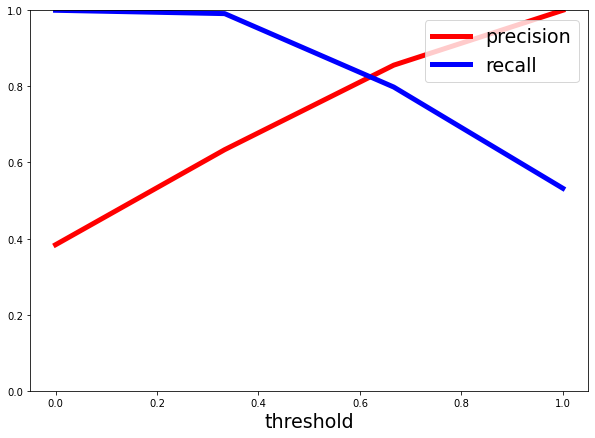

model type: DecisionTreeClassifier


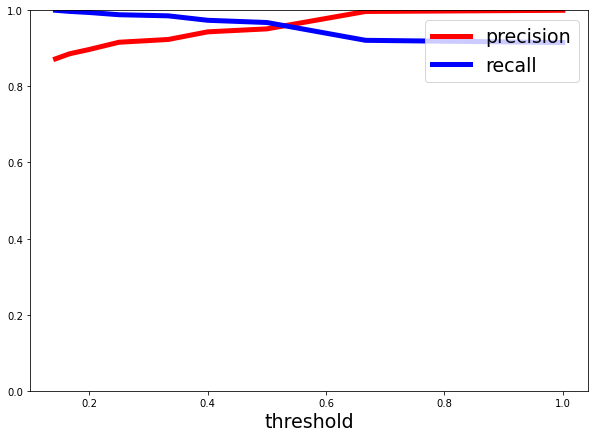

model type: RandomForestClassifier


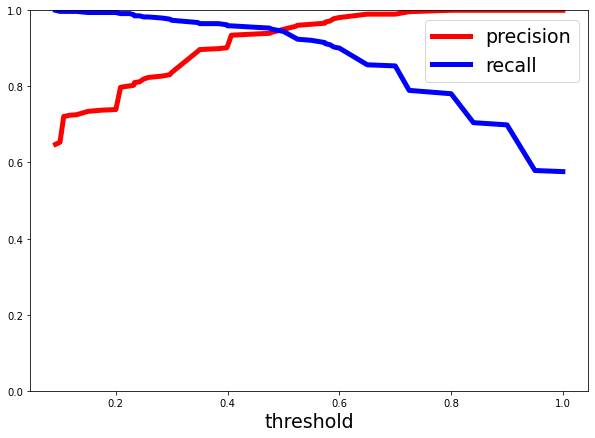

In [363]:
for classifier in [knn, decision_tree, final_random_forest_model]:
    y_scores = classifier.predict_proba(X_train)
    y_scores = y_scores[:,1]

    precision, recall, threshold = precision_recall_curve(y_train, y_scores)

    print(f'model type: {classifier.__class__.__name__}')
    plt.figure(figsize=(10, 7))
    plot_precision_and_recall(precision, recall, threshold)
    plt.show()

### ROC Curve

Another way to compare the binary classifiers is using an ROC curve. Let us show the relevant plots:

In [365]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

model type: KNeighborsClassifier
ROC AUC Score: 0.9403673878077099


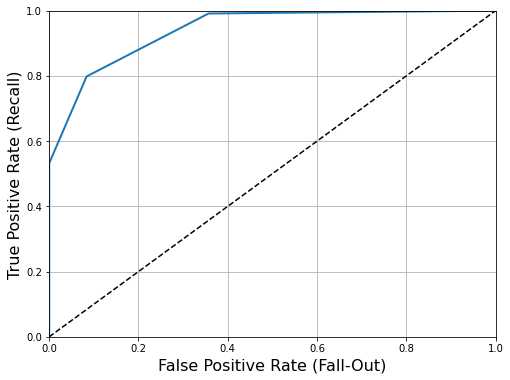

model type: DecisionTreeClassifier
ROC AUC Score: 0.997518081786129


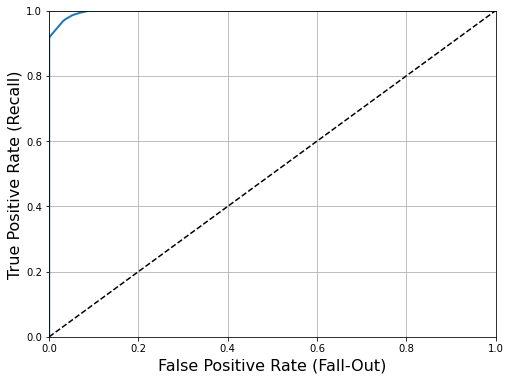

model type: RandomForestClassifier
ROC AUC Score: 0.9921334909830739


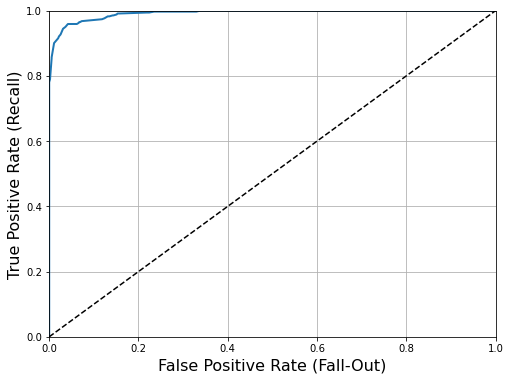

In [375]:
for classifier in [knn, decision_tree, final_random_forest_model]:
    y_scores = classifier.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, 1])
    print(f'model type: {classifier.__class__.__name__}')
    r_a_score = roc_auc_score(y_train, y_scores[:, 1])
    print("ROC AUC Score:", r_a_score)
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    plt.show()

The straight dashed line represents a random classifier (a coin flip). It seems that our three classifiers are much better than random, thankfully.